In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [9]:
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import torch
import os
import numpy as np
import pandas as pd

## Load in Dataset

In [3]:
train_data, test_data = read_processed_data(cross_domain=True, augmented=False, balanced=False)

## Logistic Regression

### Extract data and label mapping

In [13]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col="text", label_col="label")

### Transform to Vectors

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

if os.path.isdir("embeddings"):
    X_train_emb = np.load("embeddings/X_train_emb.npy")
    X_test_emb = np.load("embeddings/X_test_emb.npy")
else:
    X_train_emb = embedder.encode(
        X_train, batch_size=48, show_progress_bar=True
    )
    X_test_emb  = embedder.encode(X_test, batch_size=48)

Using device >> mps


### Train Logistic Regression Classifier

In [15]:
model = LogisticRegression(
    C=10,
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    penalty='l2',
    solver="liblinear"
)
model.fit(X_train_emb, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


### Predict and Evaluate

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.43      0.19      1478
           1       0.83      0.48      0.61      8795

    accuracy                           0.47     10273
   macro avg       0.48      0.46      0.40     10273
weighted avg       0.73      0.47      0.55     10273


Overall Metrics:
Accuracy       : 0.4719
Precision (avg): 0.7313
Recall    (avg): 0.4719
F1 Score  (avg): 0.5481



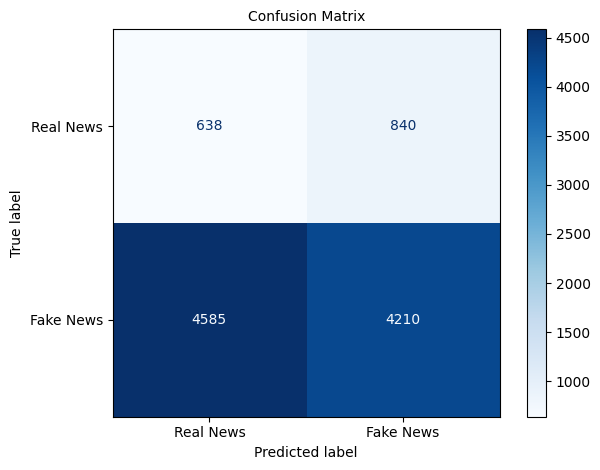

In [16]:
y_pred = model.predict(X_test_emb)

evaluate_model(y_test=y_test, y_pred=y_pred)